# Joint Motion Kernel Prediction and Deblurring (J-MKPD) demo

## Clone the repo

In [1]:
!git clone https://github.com/GuillermoCarbajal/J-MKPD.git
%cd J-MKPD

Cloning into 'J-MKPD'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 86 (delta 29), reused 57 (delta 9), pack-reused 0
Unpacking objects: 100% (86/86), done.
/home/guillermo/github/J-MKPD/J-MKPD


## Setup the environment

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -r 'requirements.txt'
#!pip install -r '/content/drive/MyDrive/BlindNIMBUSR/requirements.txt'
!pip install --upgrade --no-cache-dir gdown
!python3 setup.py develop --no_cuda_ext

Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
    100% |████████████████████████████████| 71kB 2.3MB/s ta 0:00:01
    100% |████████████████████████████████| 81kB 5.7MB/s ta 0:00:011
    100% |████████████████████████████████| 122kB 20.6MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 37.5MB/s ta 0:00:01
    100% |████████████████████████████████| 153kB 33.2MB/s ta 0:00:01
    100% |████████████████████████████████| 143kB 47.3MB/s ta 0:00:01
    100% |████████████████████████████████| 184kB 48.1MB/s ta 0:00:01
  Running setup.py install for scandir ... done
  Running setup.py install for gdown ... done
python3: can't open file 'setup.py': [Errno 2] No such file or directory


## Download pretrained models

In [4]:
import gdown
gdown.download('http://iie.fing.edu.uy/~carbajal/IEEE_CI_models/COCO900_restL2_sat/80000_kernels_network.pth', "./pretrained_models/", quiet=False)
gdown.download('http://iie.fing.edu.uy/~carbajal/IEEE_CI_models/COCO900_restL2_sat/80000_G.pth', "./pretrained_models/", quiet=False)

Downloading...
From: http://iie.fing.edu.uy/~carbajal/IEEE_CI_models/COCO900_restL2_sat/80000_kernels_network.pth
To: /content/pretrained_models/80000_kernels_network.pth
100%|██████████| 319M/319M [02:36<00:00, 2.04MB/s]
Downloading...
From: http://iie.fing.edu.uy/~carbajal/IEEE_CI_models/COCO900_restL2_sat/80000_G.pth
To: /content/pretrained_models/80000_G.pth
100%|██████████| 68.1M/68.1M [00:51<00:00, 1.32MB/s]


'./pretrained_models/80000_G.pth'

In [5]:
%cd /content/drive/MyDrive/BlindNIMBUSR

/content/drive/MyDrive/BlindNIMBUSR


In [18]:
import torch
from skimage.io import imread, imsave
from skimage import img_as_ubyte
import os 
from models.TwoHeadsNetwork import TwoHeadsNetwork
from torchvision import transforms
import numpy as np
from torchvision.utils import make_grid
from utils.visualization import save_kernels_grid, save_image, tensor2im
from matplotlib import pyplot  as plt
from skimage.color import gray2rgb
from skimage.transform import resize

In [7]:
%ls

BlindNIMBUSR_demo.ipynb  image_superresolution.py  requirements.txt  utils/
compute_kernels.py       models/                   testing_imgs/
image_deblurring.py      README.md                 testing_results/


## Kernels Computation

In [38]:
input_image = '/content/drive/MyDrive/BlindNIMBUSR/testing_imgs/0249.png'
#input_image = '/content/drive/MyDrive/BlindNIMBUSR/testing_imgs/0316.png'
reblur_model_file = '/content/pretrained_models/80000_kernels_network.pth'

K=25
reblur_model = TwoHeadsNetwork(K).cuda()   
reblur_model.load_state_dict(torch.load(reblur_model_file))
reblur_model.eval()

TwoHeadsNetwork(
  (inc_rgb): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (inc_gray): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (down1): Down(
    (double_conv): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (down_sampling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down2): Down(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), pad

In [39]:
def compute_kernels(input_file, reblur_model, output_dir='testing_results', gamma_factor=1.0):
  
  K = 25 # number of elements en the base
  if not os.path.exists(output_dir):
      os.makedirs(output_dir)

  img_name = input_file.split('/')[-1]
  img_name, ext = img_name.split('.')

  print('loading image ',input_file)
  blurry_image = imread(input_file)

  # Blurry image is transformed to pytorch format
  transform = transforms.Compose([
      transforms.ToTensor()
  ])
  blurry_tensor = transform(blurry_image).cuda()

  # Kernels and masks are estimated
  blurry_tensor_to_compute_kernels = blurry_tensor**gamma_factor - 0.5
  kernels_estimated, masks_estimated = reblur_model(blurry_tensor_to_compute_kernels[None,:,:,:])

  kernels_val_n = kernels_estimated[0, :, :, :]
  kernels_val_n_ext = kernels_val_n[:, np.newaxis, :, :]

  blur_kernel_val_grid = make_grid(kernels_val_n_ext, nrow=K,
                                                    normalize=True, scale_each=True,pad_value=1)
  mask_val_n = masks_estimated[0, :, :, :]
  mask_val_n_ext = mask_val_n[:, np.newaxis, :, :]
  blur_mask_val_grid = make_grid(mask_val_n_ext, nrow=K, pad_value=1)

  imsave(os.path.join(output_dir, img_name + '_kernels.png' ),
            img_as_ubyte(blur_kernel_val_grid.detach().cpu().numpy().transpose((1, 2, 0))))
  print('Kernels saved in ',os.path.join(output_dir, img_name + '_kernels.png') )

  imsave(os.path.join(output_dir, img_name + '_masks.png' ),
            img_as_ubyte(blur_mask_val_grid.detach().cpu().numpy().transpose((1, 2, 0))))
  print('Mixing coefficients saved in ',os.path.join(output_dir, img_name + '_mask.png' ))

  win_kernels_grid = save_kernels_grid(blurry_tensor, torch.flip(kernels_estimated[0], dims=(1,2)), masks_estimated[0], os.path.join(output_dir, img_name + '_kernels_grid.png'))
  print(win_kernels_grid.shape, win_kernels_grid.min(), win_kernels_grid.max())
  print('Kernels grid saved in ',os.path.join(output_dir, img_name + '_kernels_grid.png' ))

  plt.figure(figsize=(14,7))
  plt.subplot(1,2,1)
  plt.imshow(blurry_image)
  plt.subplot( 1,2,2)
  plt.imshow(win_kernels_grid)



loading image  /content/drive/MyDrive/BlindNIMBUSR/testing_imgs/0249.png
Kernels saved in  testing_results/0249_kernels.png


/content/drive/MyDrive/BlindNIMBUSR/models/TwoHeadsNetwork.py:206: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
/content/drive/MyDrive/BlindNIMBUSR/models/TwoHeadsNetwork.py:207: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  diffY // 2, diffY - diffY // 2])


Mixing coefficients saved in  testing_results/0249_mask.png
(288, 288, 3) 0 255
Kernels grid saved in  testing_results/0249_kernels_grid.png


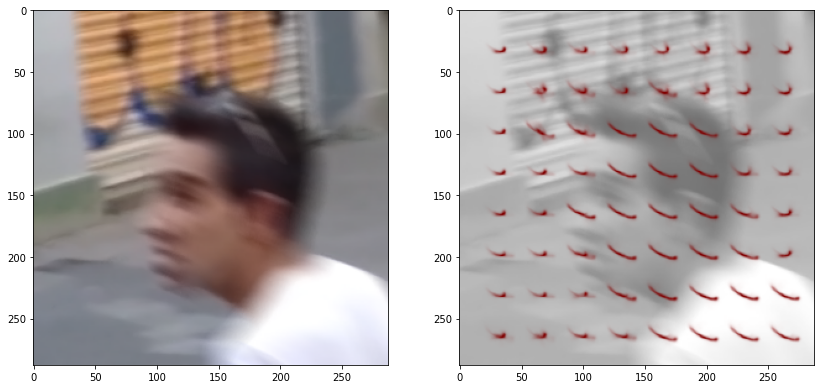

In [40]:
compute_kernels(input_image, reblur_model)

## Image Deblurring

In [41]:
from models.network_nimbusr import NIMBUSRforSI as netForSI
from models.network_nimbusr import NIMBUSR as net

In [42]:
def load_nimbusr_net(type='nimbusr'):
    opt_net = { "n_iter": 8
        , "h_nc": 64
        , "in_nc": 4
        , "out_nc": 3
        , "ksize": 25
        , "nc": [64, 128, 256, 512]
        , "nb": 2
        , "gc": 32
        , "ng": 2
        , "reduction" : 16
        , "act_mode": "R" 
        , "upsample_mode": "convtranspose" 
        , "downsample_mode": "strideconv"}

    opt_data = { "phase": "train"
          , "dataset_type": "usrnet_multiblur"
          , "dataroot_H": "datasets/COCO/val2014"
          , "dataroot_L": None
          , "H_size": 256
          , "use_flip": True
          , "use_rot": True
          , "scales": [2]
          , "sigma": [0, 2]
          , "sigma_test": 15
          , "n_channels": 3
          , "dataloader_shuffle": True
          , "dataloader_num_workers": 16
          , "dataloader_batch_size": 16
          , "motion_blur": True

          , "coco_annotation_path": "datasets/COCO/instances_val2014.json"}

    path_pretrained = restoration_model #r'../model_zoo/NIMBUSR.pth'
    
    if type=='nimbusr':
        netG = net(n_iter=opt_net['n_iter'],
                    h_nc=opt_net['h_nc'],
                    in_nc=opt_net['in_nc'],
                    out_nc=opt_net['out_nc'],
                    nc=opt_net['nc'],
                    nb=opt_net['nb'],
                    act_mode=opt_net['act_mode'],
                    downsample_mode=opt_net['downsample_mode'],
                    upsample_mode=opt_net['upsample_mode']
                    )
    elif type=='nimbusr_sat':
        netG = netForSI(n_iter= opt_net['n_iter'],
                    h_nc=opt_net['h_nc'],
                    in_nc=opt_net['in_nc'],
                    out_nc=opt_net['out_nc'],
                    nc=opt_net['nc'],
                    nb=opt_net['nb'],
                    act_mode=opt_net['act_mode'],
                    downsample_mode=opt_net['downsample_mode'],
                    upsample_mode=opt_net['upsample_mode']
                    )

    netG.load_state_dict(torch.load(path_pretrained))
    netG = netG.to('cuda')

    return netG


In [49]:
def restore_images(input_file, reblur_model, output_folder='testing_results', gamma_factor=1.0, 
                   resize_factor=1, network_type='nimbusr_sat'):
  
  if not os.path.exists(output_folder):
    os.makedirs(output_folder)

  blurry_image =  imread(input_file)
  img_name, ext = input_file.split('/')[-1].split('.')
  
  if len(blurry_image.shape) > 2:
      blurry_image = blurry_image[:,:,:3]
  else:
      blurry_image = np.concatenate((blurry_image[:,:,None],blurry_image[:,:,None],blurry_image[:,:,None]), axis=2)

  M, N, C = blurry_image.shape
  if resize_factor != 1:
    if len(blurry_image.shape) == 2:
        blurry_image = gray2rgb(blurry_image)
    new_shape = (int(resize_factor*M), int(resize_factor*N), C )
    blurry_image = resize(blurry_image,new_shape, anti_aliasing=True).astype(np.float32)


  initial_image = blurry_image.copy()

  blurry_tensor = transforms.ToTensor()(blurry_image)
  blurry_tensor = blurry_tensor[None,:,:,:]
  blurry_tensor = blurry_tensor.cuda()

  save_image(tensor2im(blurry_tensor[0] - 0.5), os.path.join(output_folder, img_name + '.png' ))

  with torch.no_grad():
      blurry_tensor_to_compute_kernels = blurry_tensor**gamma_factor - 0.5
      kernels, masks = two_heads(blurry_tensor_to_compute_kernels)
      save_kernels_grid(blurry_tensor[0],kernels[0], masks[0], os.path.join(output_folder, img_name + '_kernels'+'.png'))


  noise_level = 0.01
  with torch.no_grad():
      netG = load_nimbusr_net(network_type)
      noise_level = torch.FloatTensor([noise_level]).view(1,1,1).cuda()
      kernels_flipped = torch.flip(kernels, dims=(2, 3))
      output = netG(blurry_tensor, masks, kernels_flipped, 1, sigma=noise_level[None,:])
      print('Restored image range:', output.min(), output.max())

  #output_img = tensor2im(torch.clamp(output[0]/output[0].max(),0,1) - 0.5)
  output_img = tensor2im(torch.clamp(output[0],0,1) - 0.5)
  save_image(output_img, os.path.join(output_folder, img_name  + '_restored.png' ))
  print('Output saved in ', os.path.join(output_folder, img_name  + '_restored.png' ))

  plt.figure(figsize=(14,7))
  plt.subplot(1,2,1)
  plt.imshow(blurry_image)
  plt.subplot( 1,2,2)
  plt.imshow(output_img)


In [50]:
input_image = '/content/drive/MyDrive/BlindNIMBUSR/testing_imgs/0249.png'
restoration_model='/content/pretrained_models/80000_G.pth'

Restored image range: tensor(0.0257, device='cuda:0') tensor(1.1559, device='cuda:0')
Output saved in  testing_results/0249_restored.png


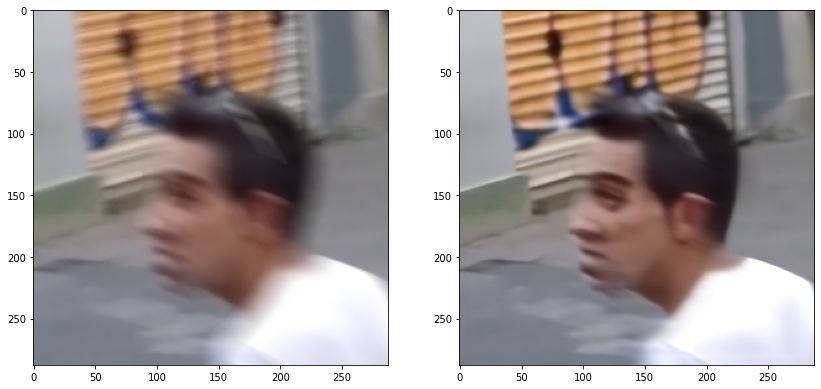

In [51]:
restore_images(input_image, reblur_model)

## Try with your own images

In [52]:
from google.colab import files
import shutil

upload_folder = 'upload/input'
result_folder = 'upload/output'

if os.path.isdir(upload_folder):
    shutil.rmtree(upload_folder)
if os.path.isdir(result_folder):
    shutil.rmtree(result_folder)
os.makedirs(upload_folder)
os.makedirs(result_folder)

# upload images
uploaded = files.upload()
for filename in uploaded.keys():
  dst_path = os.path.join(upload_folder, filename)
  print(f'move {filename} to {dst_path}')
  shutil.move(filename, dst_path)

Saving face.jpg to face.jpg
Saving car1.jpg to car1.jpg
move face.jpg to upload/input/face.jpg
move car1.jpg to upload/input/car1.jpg


Restored image range: tensor(-0.0342, device='cuda:0') tensor(1.7247, device='cuda:0')
Output saved in  testing_results/car1_restored.png
Restored image range: tensor(-0.1565, device='cuda:0') tensor(1.5121, device='cuda:0')
Output saved in  testing_results/face_restored.png


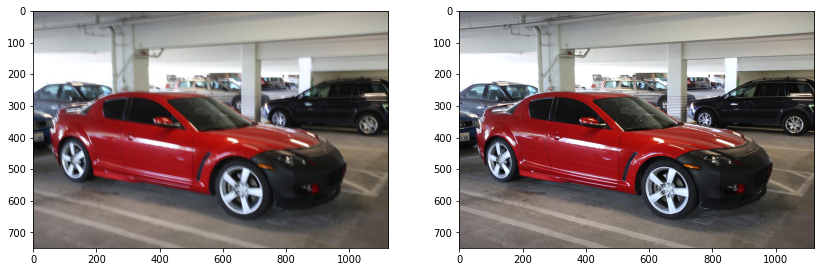

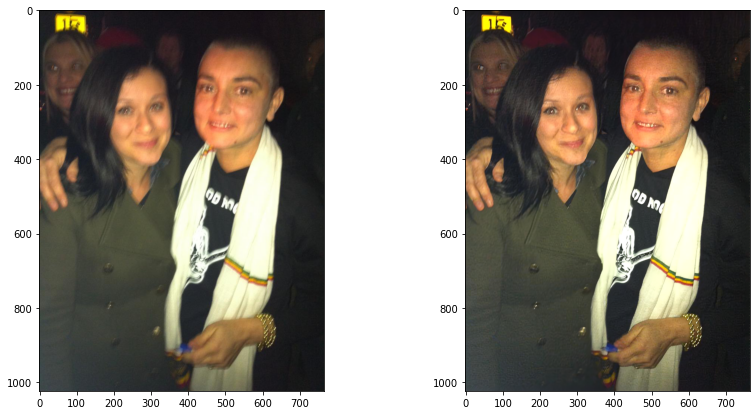

In [53]:
import glob
input_list = sorted(glob.glob(os.path.join(upload_folder, '*')))
for input_path in input_list:
  img_input = imread(input_path)
  restore_images(input_path, reblur_model)